In [1]:
!pip install torch torchvision opencv-python matplotlib imutils
!pip install timm torch torchvision opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from PIL import Image
import imutils
import timm  # EfficientNet is available through the timm library
from torchvision.datasets import ImageFolder
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torchvision.models as models
import random
from torchvision import transforms
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/dataset"

Cropping images

In [5]:
def crop_brain_tumor(image):
    """
    Automatically detects the largest contour in the image and crops the tumor region.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary threshold
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return image  # Return original if no tumor found

    # Get largest contour
    c = max(cnts, key=cv2.contourArea)

    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Apply cropping
    ADD_PIXELS = 10  # Add padding
    cropped_image = image[max(0, extTop[1]-ADD_PIXELS):extBot[1]+ADD_PIXELS,
                          max(0, extLeft[0]-ADD_PIXELS):extRight[0]+ADD_PIXELS]

    return cropped_image

Data augmentation

In [6]:
class CustomTransform:
    def __call__(self, img):
        # Convert PIL image to NumPy array for OpenCV processing
        img_np = np.array(img)

        # Apply brain tumor cropping
        cropped_img = crop_brain_tumor(img_np)

        # Convert back to PIL Image for torchvision transformations
        img_pil = Image.fromarray(cropped_img)

        # Apply augmentations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to standard size
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop randomly
            transforms.RandomRotation(30),  # Random rotation
            transforms.RandomHorizontalFlip(),  # Randomly flip image
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color augmentation
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

        return transform(img_pil)

Importing dataset

In [7]:
dataset = datasets.ImageFolder(root=dataset_path, transform=CustomTransform())
# Print class names
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Train-validation split

In [8]:
# Define train-validation split
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Training images: {len(train_ds)}, Validation images: {len(val_ds)}, test images: {len(test_ds)}")

Training images: 2212, Validation images: 632, test images: 316


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(20),  # Rotate images randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformations only to the training set
train_ds.dataset.transform = train_transform

Visulization

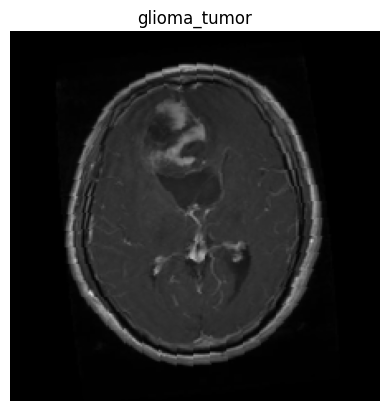

In [10]:
def imshow(img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(class_names[label])
    plt.axis("off")
    plt.show()

# Get one batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the first image
imshow(images[0], labels[0].item())

## **1.SWIN :**

In [11]:
# Charger Swin-Tiny pré-entraîné
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(dataset.classes))

# Définir l'appareil (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze the early layers and fine-tune the last few layers (classifier head)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the classifier layer (head)
for param in model.head.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs} - Perte: {running_loss/len(train_loader):.4f}")

print("Entraînement terminé !")

# Evaluation on the validation set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accurancy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Époque 1/20 - Perte: 1.3067
Époque 2/20 - Perte: 1.1785
Époque 3/20 - Perte: 1.0963
Époque 4/20 - Perte: 1.0180
Époque 5/20 - Perte: 0.9585
Époque 6/20 - Perte: 0.9031
Époque 7/20 - Perte: 0.8699
Époque 8/20 - Perte: 0.8336
Époque 9/20 - Perte: 0.8036
Époque 10/20 - Perte: 0.7748
Époque 11/20 - Perte: 0.7547
Époque 12/20 - Perte: 0.7373
Époque 13/20 - Perte: 0.7328
Époque 14/20 - Perte: 0.7005
Époque 15/20 - Perte: 0.6862
Époque 16/20 - Perte: 0.6825
Époque 17/20 - Perte: 0.6765
Époque 18/20 - Perte: 0.6558
Époque 19/20 - Perte: 0.6537
Époque 20/20 - Perte: 0.6304
Entraînement terminé !
Accurancy: 76.90%


# a.Test Model :

In [12]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the model (using your trained model)
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.8291
                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.79      0.83        98
meningioma_tumor       0.77      0.74      0.76        88
        no_tumor       0.83      0.89      0.86        27
 pituitary_tumor       0.83      0.93      0.88       103

        accuracy                           0.83       316
       macro avg       0.83      0.84      0.83       316
    weighted avg       0.83      0.83      0.83       316



# b.Test Random Image

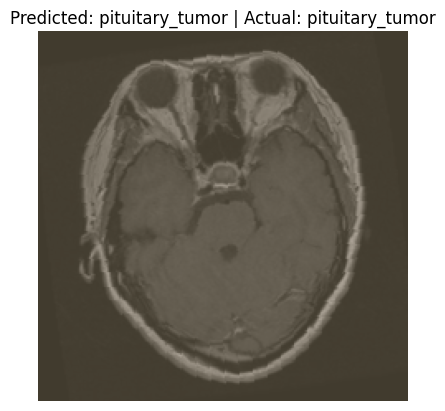

Predicted Label: pituitary_tumor
Actual Label: pituitary_tumor


In [13]:
def test_random_image(model, test_loader, device, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Normalize the image to match the Swin-Tiny's input normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Ensure the image is in the correct range

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **2.ResNeT**

In [14]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final one (fc layer)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the final classifier layer
for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze the classifier layer

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer should only optimize the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass to get predictions
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        loss.backward()

        # Step the optimizer to update the weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


Epoch 1/20 - Loss: 1.3694
Epoch 2/20 - Loss: 1.2185
Epoch 3/20 - Loss: 1.1274
Epoch 4/20 - Loss: 1.0531
Epoch 5/20 - Loss: 1.0042
Epoch 6/20 - Loss: 0.9457
Epoch 7/20 - Loss: 0.9051
Epoch 8/20 - Loss: 0.8703
Epoch 9/20 - Loss: 0.8417
Epoch 10/20 - Loss: 0.8308
Epoch 11/20 - Loss: 0.8018
Epoch 12/20 - Loss: 0.7772
Epoch 13/20 - Loss: 0.7588
Epoch 14/20 - Loss: 0.7462
Epoch 15/20 - Loss: 0.7386
Epoch 16/20 - Loss: 0.7161
Epoch 17/20 - Loss: 0.7075
Epoch 18/20 - Loss: 0.6996
Epoch 19/20 - Loss: 0.6963
Epoch 20/20 - Loss: 0.6756
Training complete!
Accuracy: 78.16%


# a.Test Model :

In [15]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the ResNet18 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.8196
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.77      0.83        98
meningioma_tumor       0.71      0.81      0.76        88
        no_tumor       0.73      0.70      0.72        27
 pituitary_tumor       0.87      0.91      0.89       103

        accuracy                           0.82       316
       macro avg       0.81      0.80      0.80       316
    weighted avg       0.83      0.82      0.82       316



# b.Test Random Image

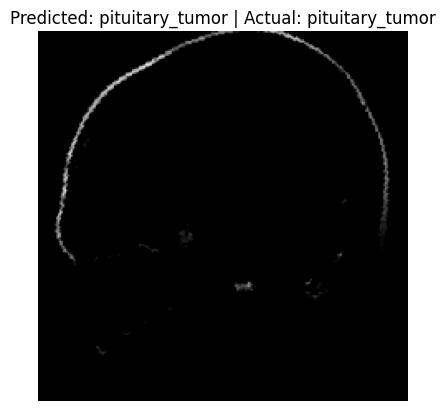

Predicted Label: pituitary_tumor
Actual Label: pituitary_tumor


In [16]:
# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **3.VGG16**

In [17]:

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False
# Unfreeze the final classifier layer
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Pass only the parameters of the final layer to the optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 119MB/s]


Epoch 1/20 - Loss: 1.2263
Epoch 2/20 - Loss: 1.0271
Epoch 3/20 - Loss: 0.9187
Epoch 4/20 - Loss: 0.8706
Epoch 5/20 - Loss: 0.8320
Epoch 6/20 - Loss: 0.7937
Epoch 7/20 - Loss: 0.7790
Epoch 8/20 - Loss: 0.7586
Epoch 9/20 - Loss: 0.7412
Epoch 10/20 - Loss: 0.7330
Epoch 11/20 - Loss: 0.7053
Epoch 12/20 - Loss: 0.7000
Epoch 13/20 - Loss: 0.7169
Epoch 14/20 - Loss: 0.7030
Epoch 15/20 - Loss: 0.6896
Epoch 16/20 - Loss: 0.6888
Epoch 17/20 - Loss: 0.6827
Epoch 18/20 - Loss: 0.6755
Epoch 19/20 - Loss: 0.6630
Epoch 20/20 - Loss: 0.6633
Training complete!
Accuracy: 75.00%


# a.Test Model :

In [18]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the VGG16 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7500
                  precision    recall  f1-score   support

    glioma_tumor       0.75      0.78      0.76        98
meningioma_tumor       0.74      0.56      0.64        88
        no_tumor       0.67      0.74      0.70        27
 pituitary_tumor       0.78      0.89      0.83       103

        accuracy                           0.75       316
       macro avg       0.73      0.74      0.73       316
    weighted avg       0.75      0.75      0.74       316



# b.Test Random Image

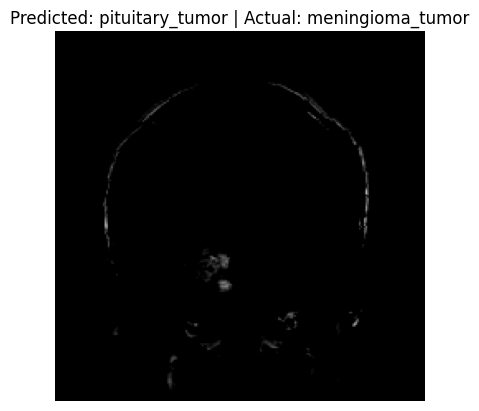

Predicted Label: pituitary_tumor
Actual Label: meningioma_tumor


In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **4.EfficientNet**

In [20]:
# Load pre-trained EfficientNet-B0 model
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the final layer to match the number of classes
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer should only optimize the parameters of the final classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/20 - Loss: 1.2556
Epoch 2/20 - Loss: 1.0842
Epoch 3/20 - Loss: 0.9879
Epoch 4/20 - Loss: 0.9123
Epoch 5/20 - Loss: 0.8412
Epoch 6/20 - Loss: 0.7965
Epoch 7/20 - Loss: 0.7626
Epoch 8/20 - Loss: 0.7409
Epoch 9/20 - Loss: 0.6986
Epoch 10/20 - Loss: 0.6868
Epoch 11/20 - Loss: 0.6747
Epoch 12/20 - Loss: 0.6554
Epoch 13/20 - Loss: 0.6410
Epoch 14/20 - Loss: 0.6342
Epoch 15/20 - Loss: 0.6109
Epoch 16/20 - Loss: 0.6050
Epoch 17/20 - Loss: 0.5982
Epoch 18/20 - Loss: 0.5874
Epoch 19/20 - Loss: 0.5900
Epoch 20/20 - Loss: 0.5684
Training complete!
Accuracy: 79.11%


# a.Test Model :

In [21]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the EfficientNet-B0 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.8671
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.88      0.90        98
meningioma_tumor       0.82      0.76      0.79        88
        no_tumor       0.74      0.85      0.79        27
 pituitary_tumor       0.90      0.95      0.92       103

        accuracy                           0.87       316
       macro avg       0.84      0.86      0.85       316
    weighted avg       0.87      0.87      0.87       316



# b.Test Random Image

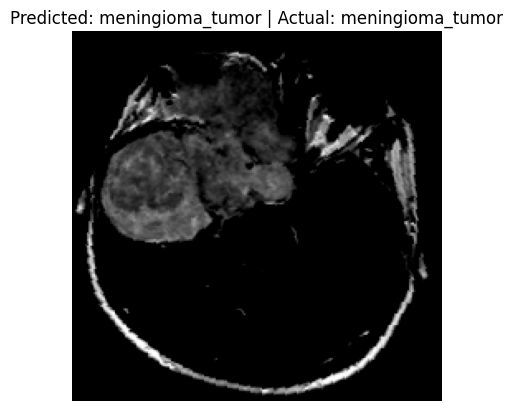

Predicted Label: meningioma_tumor
Actual Label: meningioma_tumor


In [22]:
# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)
